<a href="https://colab.research.google.com/github/cmagliano/BIMaster-Activities/blob/main/Transfer_Learning_Inceptionv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de  Imagem
Neste notebook vamos a mostrar como fazer um projeto simples de deep learning passo por passo


*   Primeiro montar a base de dados
*   Conhecer a base de dados
*   Ver como estão nossas classes
*   Utilizar transfer learning
*   Data generation e data augmentation
*   ver metricas e inferir





##Baixo os pesos de minha arquitetura

## &nbsp;&nbsp;  InceptionNets

Também conhecido como GoogleNet, consiste em um total de 22 camadas e foi o modelo vencedor do desafio de rede de imagens de 2014.

- Módulos de iniciação são o bloco fundamental de InceptionNets. A ideia principal do módulo de iniciação é projetar uma boa topologia de rede local (rede dentro de uma rede)
- Esses módulos ou blocos atuam como o extrator de recursos de vários níveis em que convoluções de tamanhos diferentes são obtidas para criar um mapa de recursos diversificado
- Os módulos de iniciação também consistem em blocos de convolução 1 x 1 cuja função é realizar a redução dimensional.
- Ao realizar a convolução 1x1, o bloco inicial preserva as dimensões espaciais, mas reduz a profundidade. Portanto, as dimensões gerais da rede não aumentam exponencialmente.
- Além da camada de saída regular, esta rede também consiste em duas saídas de classificação auxiliares que são usadas para injetar gradientes nas camadas inferiores.

<br> <br>

O módulo de iniciação é mostrado na figura a seguir:

![](https://hackathonprojects.files.wordpress.com/2016/09/inception_implement.png?w=649&h=337)

A arquitetura completa é mostrada abaixo:

![](https://cdn-images-1.medium.com/max/2000/1*uXfC5fcbDsL0TJG4T8PsVw.png)
### Pre-Trained Model : InceptionV3

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

    #Este comando não será executado pois carrega todos os pesos necessários para as camadas convolusionais mas a
    #biblioteca keras já possui estas informações

    #This command will not be executed as it carries all the necessary weights for the convolutional layers but the
    #keras library already has this information

--2023-11-18 16:57:55--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.207, 173.194.216.207, 74.125.26.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.215.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

inception_v3_weight 100%[===================>]  83.84M   122MB/s    in 0.7s    

2023-11-18 16:57:56 (122 MB/s) - ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [1]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
import numpy as np
import matplotlib.pylab as plt

##Pesos da rede

In [ ]:
weights1="/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

 #Este comando não será executado pois carrega todos os pesos necessários para as camadas convolusionais mas a
 #biblioteca keras já possui estas informações

 #This command will not be executed as it carries all the necessary weights for the convolutional layers but the
 #keras library already has this information

## &nbsp;&nbsp;  Conheciendo os dados

In [16]:
from google.colab import drive
drive.mount('/content/drive')

import os
workdir_path = '/content/drive/MyDrive/BI Master'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
os.chdir(workdir_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
print(workdir_path)
!ls

/content/drive/MyDrive/BI Master
'Aula 05 - exercícios de imagem'  'BI Master'  'exercicio 2'


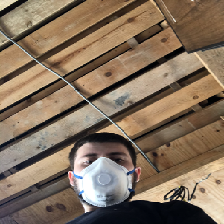

In [18]:
imagem=load_img('exercicio 2/mask/train/with_mask/image_159.png', target_size=(224,224,3));imagem

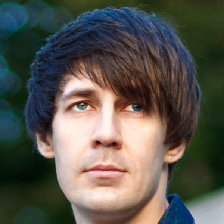

In [19]:
imagem=load_img('exercicio 2/mask/train/without_mask/image_159.png', target_size=(224,224,3));imagem

## Faço um reshape na entrada

##  Transfer Learning

<br>

Vejamos a implementação do aprendizado por transferência usando recursos de modelo pré-treinados. Trunco a rede e coloco os dados



In [20]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights='imagenet')

# pre_trained_model.load_weights(weights1)

for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

87910968/87910968 [==============================] - 6s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

In [21]:
last_layer = pre_trained_model.get_layer('mixed10') # last layer above
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output # chack the dimension

last layer output shape:  (None, 3, 3, 2048)


## Data Augmentation
###  Preparação do conjunto de dados

In [22]:
train_datagen = ImageDataGenerator(rescale = 1./255.,  #rescale para normalizar
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


test_datagen = ImageDataGenerator(rescale = 1.0/255.)


train_generator = train_datagen.flow_from_directory("exercicio 2/mask/train/",
                                                    batch_size = 10,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))

validation_generator =  test_datagen.flow_from_directory( "exercicio 2/mask/test/",
                                                          batch_size  = 10,
                                                          class_mode  = 'binary',
                                                          target_size = (150, 150),
                                                          )

Found 380 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [ ]:
validation_generator.labels[0]

0

In [23]:
validation_generator.filenames[0]

'with_mask/image_190.png'

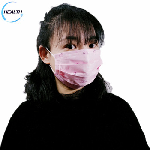

In [24]:
imagem=load_img("exercicio 2/mask/test/" + validation_generator.filenames[0], target_size=(150,150,3));
imagem

## Agora criamos uma rede da ultima camada

In [25]:
from tensorflow.keras.optimizers import Adam
#last_output = last_layer.output
x1 = layers.Flatten()(last_output)

x2 = layers.Dense(9000, activation='relu')(x1)
x3 = layers.Dropout(0.2)(x2)
x4 = layers.Dense(1, activation='sigmoid')(x3)

model = Model( pre_trained_model.input, x4)

model.compile(optimizer = Adam(lr=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

## Agora rodamos o modelo

In [26]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 20,
            epochs = 20,
            # validation_steps = 10,
            verbose = 1)

Epoch 1/20
20/20 [==============================] - 215s 10s/step - loss: 39.3943 - accuracy: 0.7150 - val_loss: 16.5040 - val_accuracy: 0.8500
Epoch 2/20
20/20 [==============================] - 70s 3s/step - loss: 8.1896 - accuracy: 0.9000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 3/20
20/20 [==============================] - 35s 2s/step - loss: 2.4222 - accuracy: 0.9550 - val_loss: 1.4945 - val_accuracy: 0.9500
Epoch 4/20
20/20 [==============================] - 21s 1s/step - loss: 1.4787 - accuracy: 0.9650 - val_loss: 2.0667 - val_accuracy: 0.9833
Epoch 5/20
20/20 [==============================] - 12s 613ms/step - loss: 0.9095 - accuracy: 0.9750 - val_loss: 1.2735 - val_accuracy: 0.9833
Epoch 6/20
20/20 [==============================] - 8s 372ms/step - loss: 1.1973 - accuracy: 0.9700 - val_loss: 1.4408 - val_accuracy: 0.9833
Epoch 7/20
20/20 [==============================] - 8s 395ms/step - loss: 0.8739 - accuracy: 0.9650 - val_loss: 1.1318 - val_accuracy: 0.9833
Epoch 8/2

##Vemos como se comportou nosso modelo

In [27]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

def PlotHistory(history):
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## indicadores de desempenho

In [28]:
score = model.evaluate_generator(validation_generator, verbose=0)
print("\nTest score:", score[0])
print('Test accuracy:', score[1])

<ipython-input-28-f0f09a9314c2>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(validation_generator, verbose=0)



Test score: 2.434936046600342
Test accuracy: 0.9833333492279053


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


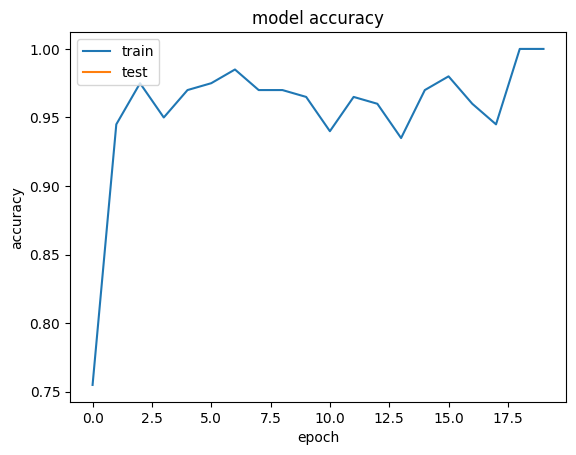

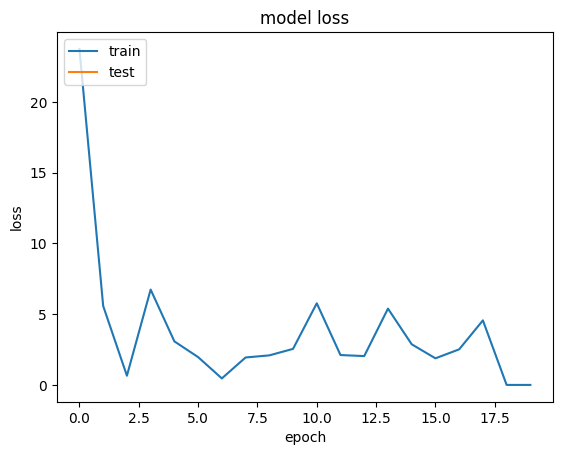

In [ ]:
PlotHistory(history)

##Inferencia do modelo

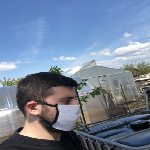

In [47]:
imagem=load_img('exercicio 2/mask/test/with_mask/image_194.png', target_size=(150,150,3));
imagem

In [48]:
imagem=np.array(imagem)


cls  = model.predict(imagem[np.newaxis,:,:,:]/255.)
print(cls)

1/1 [==============================] - 0s 26ms/step
[[0.]]
